# Problem 1f:

Code this problem up by dividing your jet into slices (making sure you use even bins
in logarithmic space!) , loop through the slices and calculate the spectum from each slice,
then add to a total spectrum for the entire jet (or technically both jets). Ideally you will
plot each component as well as the total to check that your νSSA is doing what you expect.
To test your code, use an accretion power appropriate for Sgr A*, r0 = 10rg and v = 0.3c
(but at this point don’t Lorentz transform anything, it’s not relativistic enough to be a huge
effect). Normalise your initial Lj such that either Fν in Janskys (10−23 erg/cm−2/s/Hz) or
total power per frequency bin (erg/s/Hz) matches the values for Sgr A* at 1012 Hz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import math

Begin by defining all the constants we need in cgs units

In [2]:
# define some constants
M = 4.2E6            # Mass of Sgr A* in M_sun
M_sun = 1.988e33     # Solar mass in g
Ledd = 1.26e38 * M   # Eddington luminosity in erg/s
c = 2.997e10         # Speed of light in vaccum in cm/s
G = 6.67e-8          # Gravitational constant in erg cm/g^2
rg = G*M*M_sun/c**2  # Gravitational radius in cm
me = 9.1e-28         # Electron mass in g
m_e = me
e = 4.8e-10          # Electron charge in esu
eta = 1e-7           # radiative efficiency
R0 = 10*rg           # beginning radius of the blob in cm
gam = 1000           # we know this from measurements
p = 2                # power law index
D = 26670*9.461e+17  # Distance to Sgr A* in cm

erg_to_jy = 1e23


#




In [3]:
eta_values = np.linspace(0.1, 1.5, 5) # no units
r = np.logspace(0, 3, 500)* rg #rg in cm
freq_arr = np.logspace(7, 14, 500) # hz
dr = np.ediff1d(r) # fancy 

theta = math.radians(10)  #opening angle of 10 degrees converted to radiants 
v = 0.3 * c  # (cm/s)
L_j = 9e37  # Accretion power (erg/s)
power_law_index = p

## Functions
Lets also take each of the equations and make them into functions so that we can verify each of them works as expected with a given input.



In [4]:

def magnetic_field_strength(distance):
    """
    Calculate the magnetic field strength.

    Parameters:
    - distance (float): Distance from the source.

    Returns:
    float: Magnetic field strength.
    """
    return np.sqrt(L_j / v) * 4/ distance  # other ppl have this factor of 4, whereas I dont have this
                                           # i think my solution for 1a is missing a factor of 4


def constant_parameter(distance):
    """
    Calculate a constant parameter C.

    Parameters:
    - distance (float): Distance above the source.

    Returns:
    float: Constant parameter C.
    """
    return (magnetic_field_strength(distance))**2 / (24 * np.log(10) * np.pi)


def synchrotron_emission_coef(distance, frequency, power_law_index):
    """
    Calculate the synchrotron emission coefficient.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron spectral index.
    """
    part1 = np.sqrt(3) * e**3 / (8 * np.pi * m_e)
    part2 = (3 * e / (2 * np.pi * m_e**3 * c**5))**(power_law_index/2)
    part3 = constant_parameter(distance) * (magnetic_field_strength(distance)/2)**((power_law_index+2)/2) * gamma((3*power_law_index + 2)/12)
    part4 = gamma((3*power_law_index + 22)/12) * frequency**((-power_law_index-4)/2)
    return part1 * part2 * part3 * part4

def S_freq(distance, frequency, power_law_index):
    """
    Calculate the synchrotron source function.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron source function.
    """
    return synchrotron_power(distance, frequency, power_law_index)/(4 * np.pi * synchrotron_emission_coef(distance, frequency, power_law_index))
    



def synchrotron_power(distance, frequency, power_law_index):
    """
    Calculate the synchrotron power.

    Parameters:
    - distance (float): Distance above the source
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron power.
    """
    part1 = np.sqrt(3) * e**3 * constant_parameter(distance) / (m_e * c**2) * magnetic_field_strength(distance) / (2 * m_e * c**2 * (power_law_index+1))
    part2 = gamma(power_law_index/4 + 19/12) * gamma(power_law_index/4 - 1/12) * (4 * np.pi * m_e * c * frequency/(3 * e * magnetic_field_strength(distance)))**((1-power_law_index)/2)
    return part1 * part2


def optical_depth(distance, frequency, power_law_index):
    """
    Calculate the optical depth.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Optical depth.
    """
    return synchrotron_emission_coef(distance, frequency, power_law_index) * distance



def I_freq(distance, frequency, power_law_index):
    """
    Calculate the synchrotron intensity.

    Parameters:
    - distance (float): Distance above the source.
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.

    Returns:
    float: Synchrotron intensity.
    """
    return S_freq(distance, frequency, power_law_index) * (1 - np.exp(-optical_depth(distance, frequency, power_law_index)))

def flux(distance, frequency, power_law_index, differential_distance, target_distance):
    """
    Calculate the synchrotron flux.

    Parameters:
    - distance (float): Distance above the source
    - frequency (float): Frequency.
    - power_law_index (float): Power-law index.
    - differential_distance (float): Differential distance.
    - target_distance (float): Distance to the target. 

    Returns:
    float: Synchrotron flux in ergs (CGS Units).
    """
    return  I_freq(distance, frequency, power_law_index) * distance * differential_distance * np.tan(theta/2) /(  4 * target_distance**2)


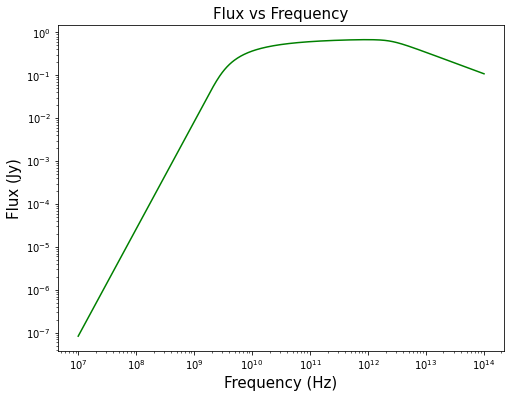

In [5]:
total_flux = np.zeros(len(freq_arr,)) # initalize 
for i, (r, dr) in enumerate(zip(r, dr)): # fancy
    flux_values = flux(r, freq_arr, 2, dr, D)  * erg_to_jy
    total_flux += flux_values

plt.figure(figsize=(8,6))
plt.plot(freq_arr, total_flux, color='green',)
plt.xlabel('Frequency (Hz)', size = 15)
plt.ylabel('Flux (Jy)', size = 15)
plt.title('Flux vs Frequency', size = 15)
plt.xscale('log')
plt.yscale('log')

## Problem 2C:

rip :((


In [6]:
rip :((

SyntaxError: unexpected EOF while parsing (1322328169.py, line 1)